In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, linalg

from matplotlib import rcParams
import scipy.stats as st

import folium # for map visualization
from folium import plugins

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

In [4]:
print("train.csv. Shape: ",df_train.shape)
print("test.csv. Shape: ",df_test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6468, 20)


## 변수 설명

ID : 집을 구분하는 번호    
date : 집을 구매한 날짜    
price : 집의 가격(Target variable)      
bedrooms : 침실의 수     
bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )       
sqft_living : 주거 공간의 평방 피트(면적)    
sqft_lot : 부지의 평방 피트(면적)   
floors : 집의 층 수     
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)     
view : 집이 얼마나 좋아 보이는지의 정도     
condition : 집의 전반적인 상태     
grade : King County grading 시스템 기준으로 매긴 집의 등급     
sqft_above : 지하실을 제외한 평방 피트(면적)     
sqft_basement : 지하실의 평방 피트(면적)     
yr_built : 지어진 년도     
yr_renovated : 집을 재건축한 년도     
zipcode : 우편번호     
lat : 위도     
long : 경도     
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)     
sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [5]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
#descriptive statistics summary
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

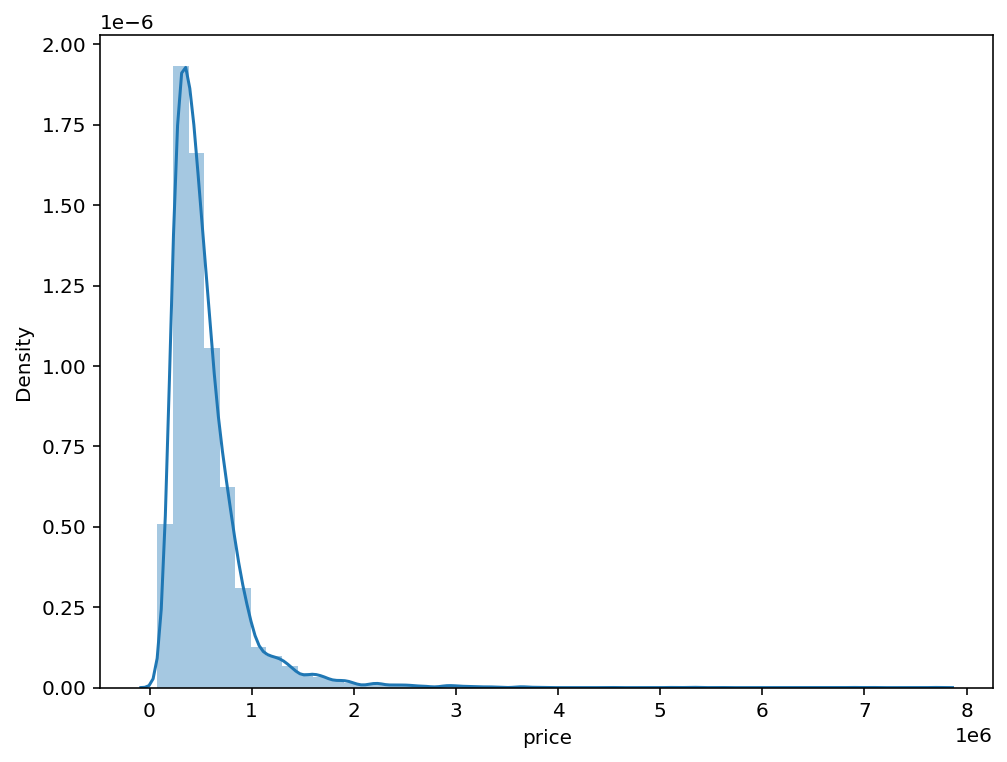

In [7]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

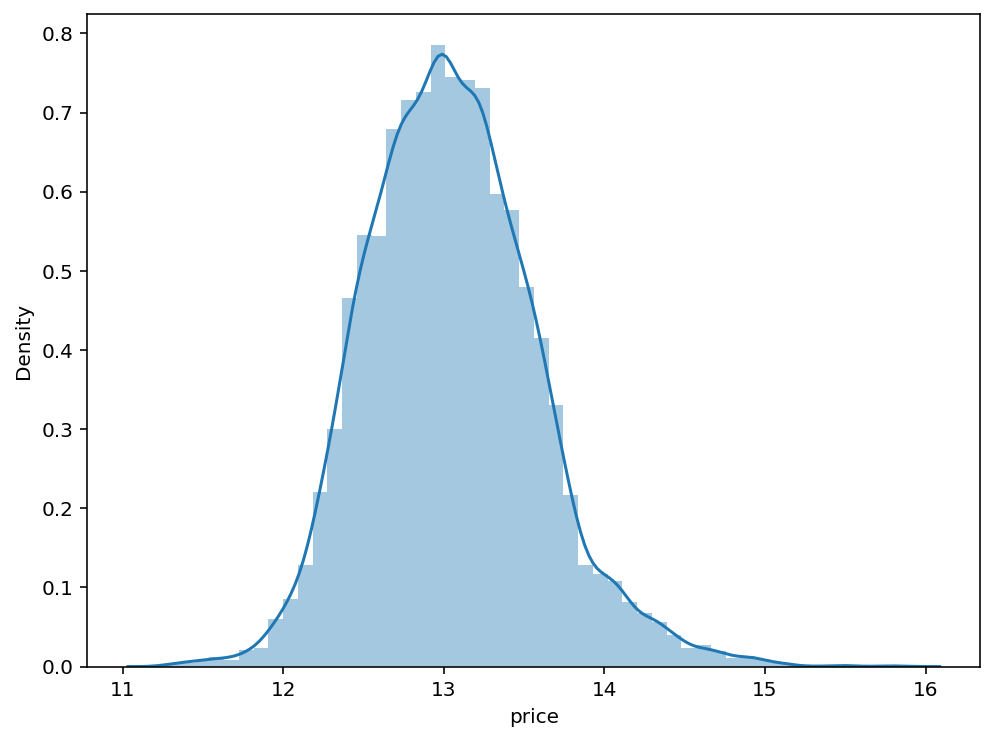

In [8]:
df_train['price'] = np.log1p(df_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

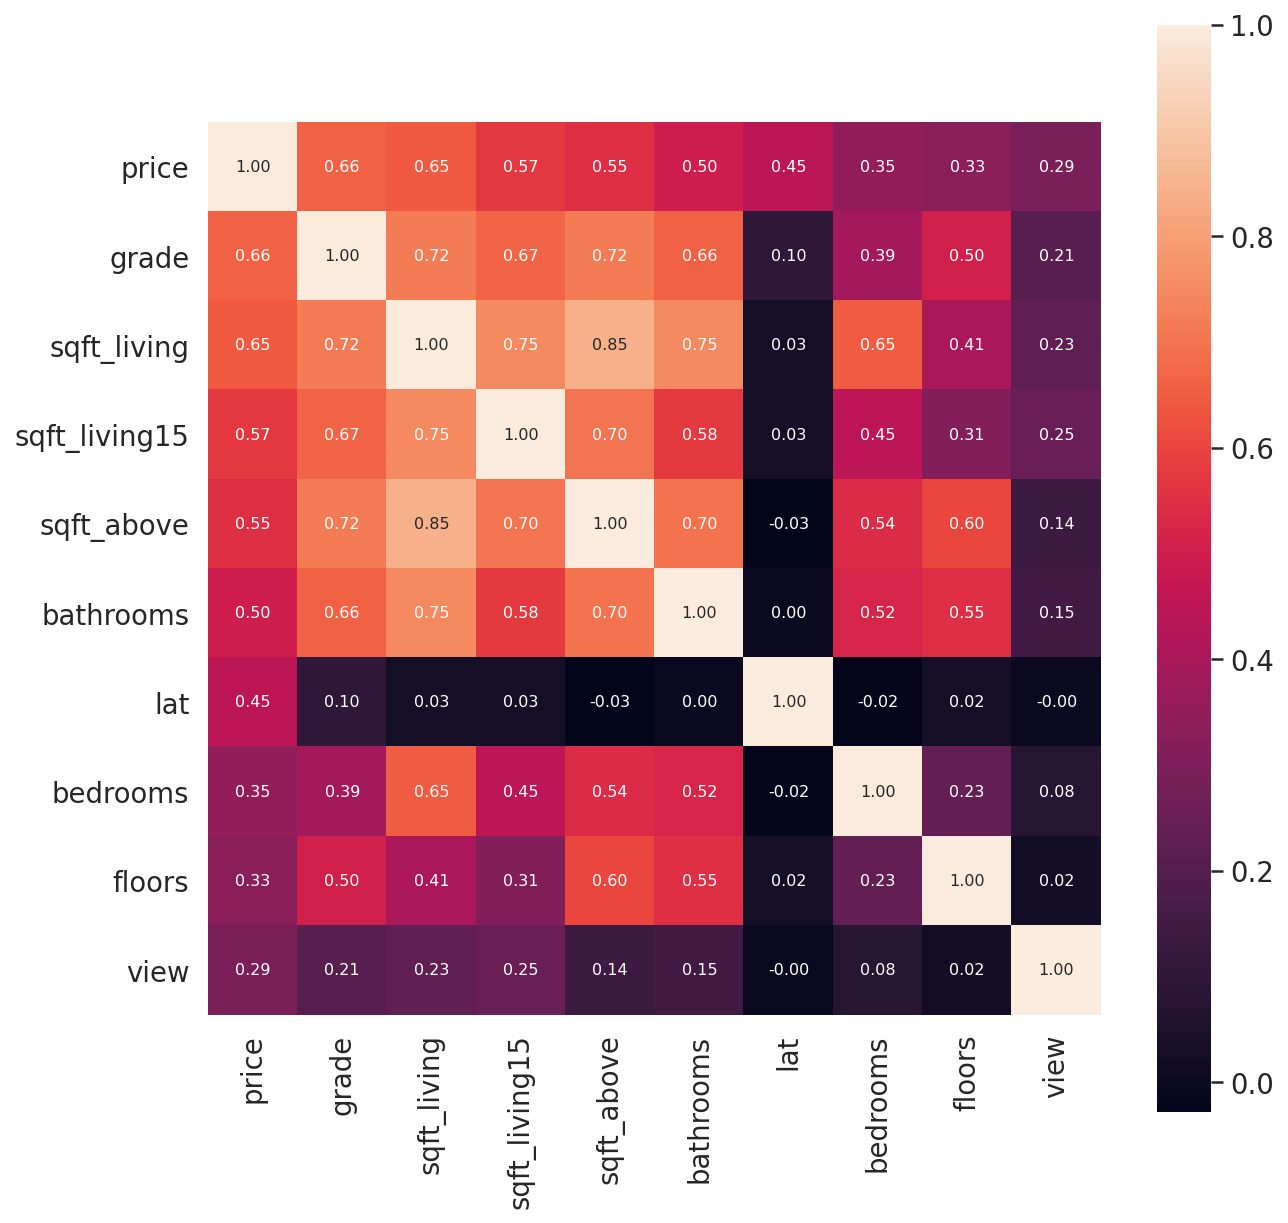

In [9]:
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

목적변수와 상관도가 높은 변수는 집의 등급 - 주거공간의 크기 - 전체 크기순이고 재미있게 lat이라는 위도 값이 들어있습니다. 
위도가 증가함에 따라 가격이 왜 증가하는지 ? 이것을 어떻게 활용할 수 있는지는 좀 더 탐색이 필요해보입니다.

https://www.kaggle.com/fulrose/eda-with-map-visualization 
이 아래서부터는 이 분의 커널을 참조하여 따라해봤습니다.

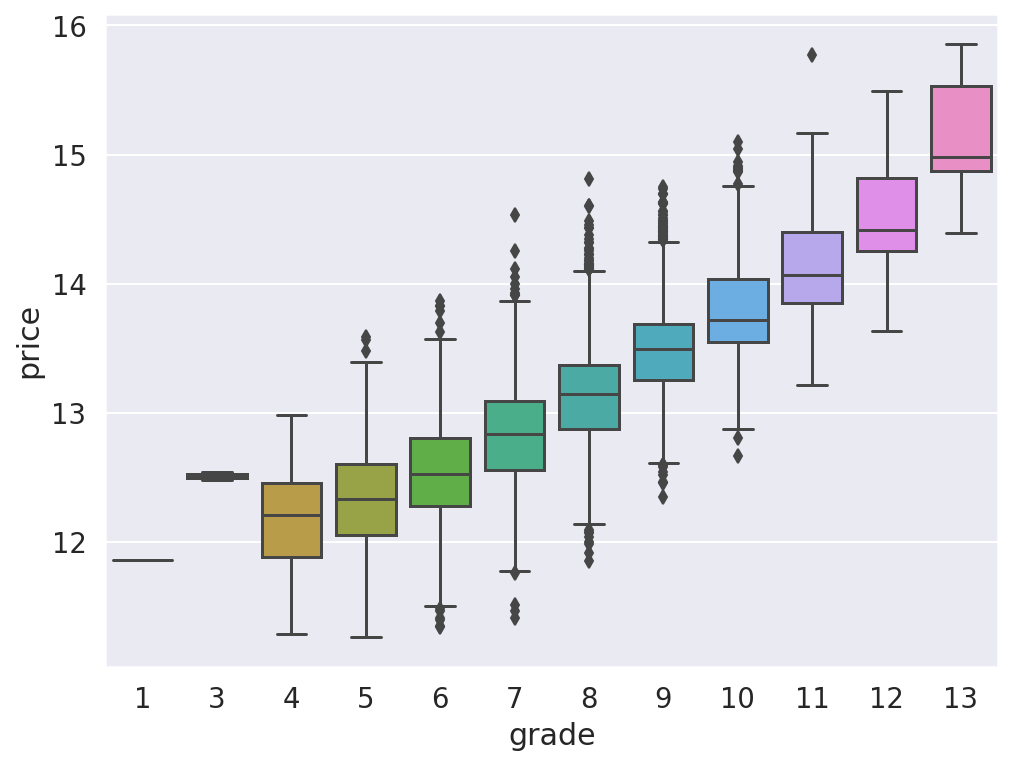

In [10]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

집의 등급이 높을수록 가격이 높아지는 것은 당연합니다. 그런데 11grade의 높은 이상치는 뭘까요,

In [11]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [12]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [13]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


다른 조건과 비교해서 가격이 높을 이유가 없기 때문에 제거해줍니다.

In [14]:
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7173]
df_train = df_train.loc[df_train['id']!=2775]

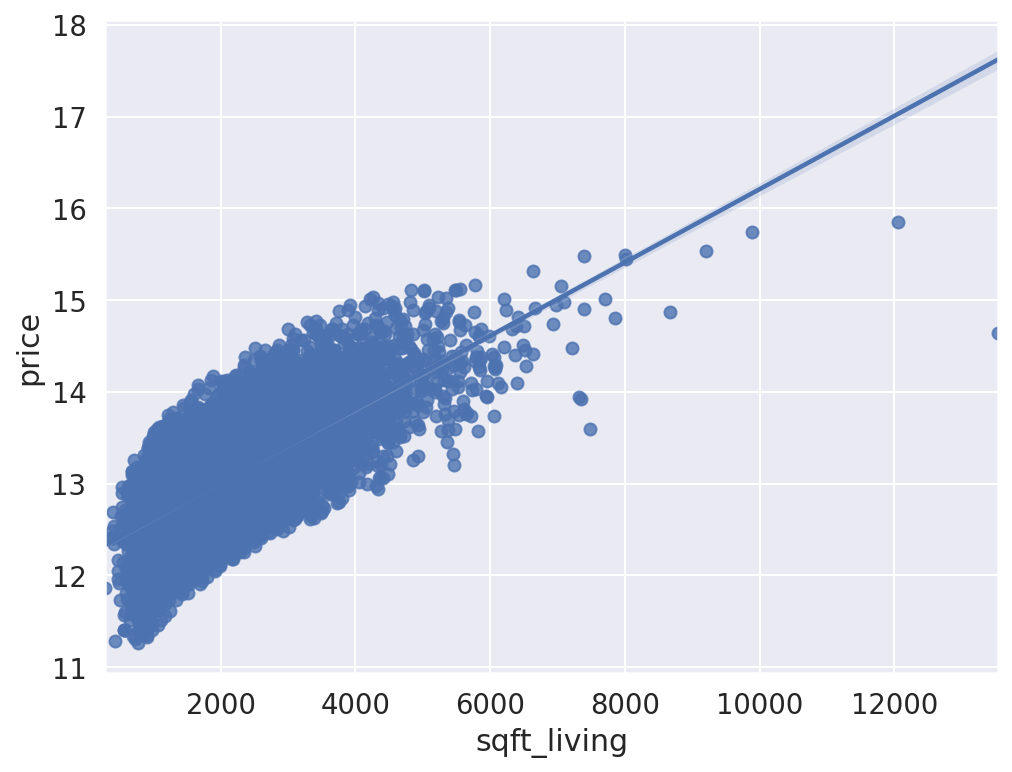

In [15]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [16]:
df_train.loc[df_train['sqft_living'] > 12000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,5108,20141013T000000,15.856731,6,8.0,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [17]:
df_train = df_train.loc[df_train['id']!=8990]
df_train = df_train.loc[df_train['id']!=5108]
#이상치로 판단하고 제거

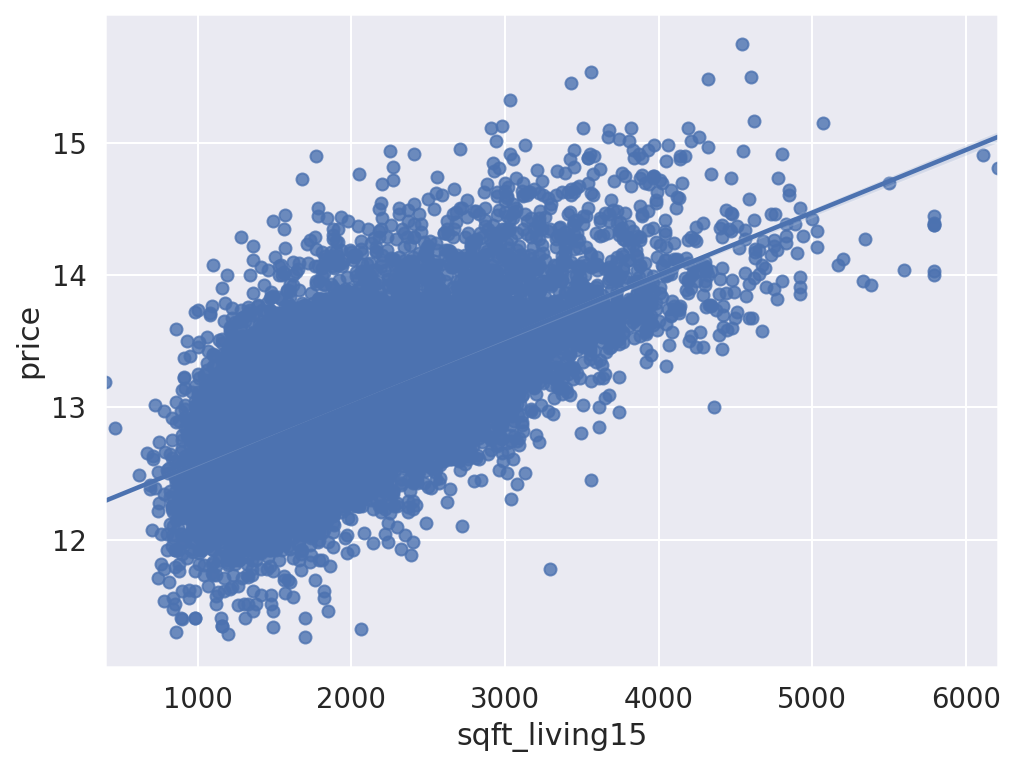

In [18]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

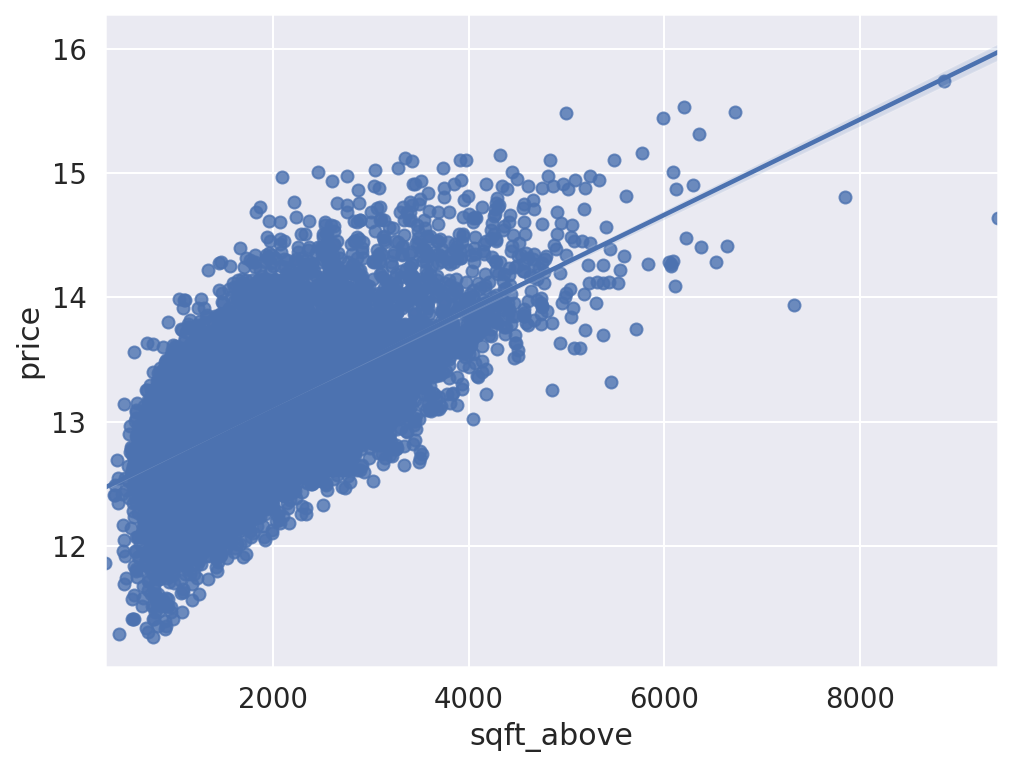

In [19]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

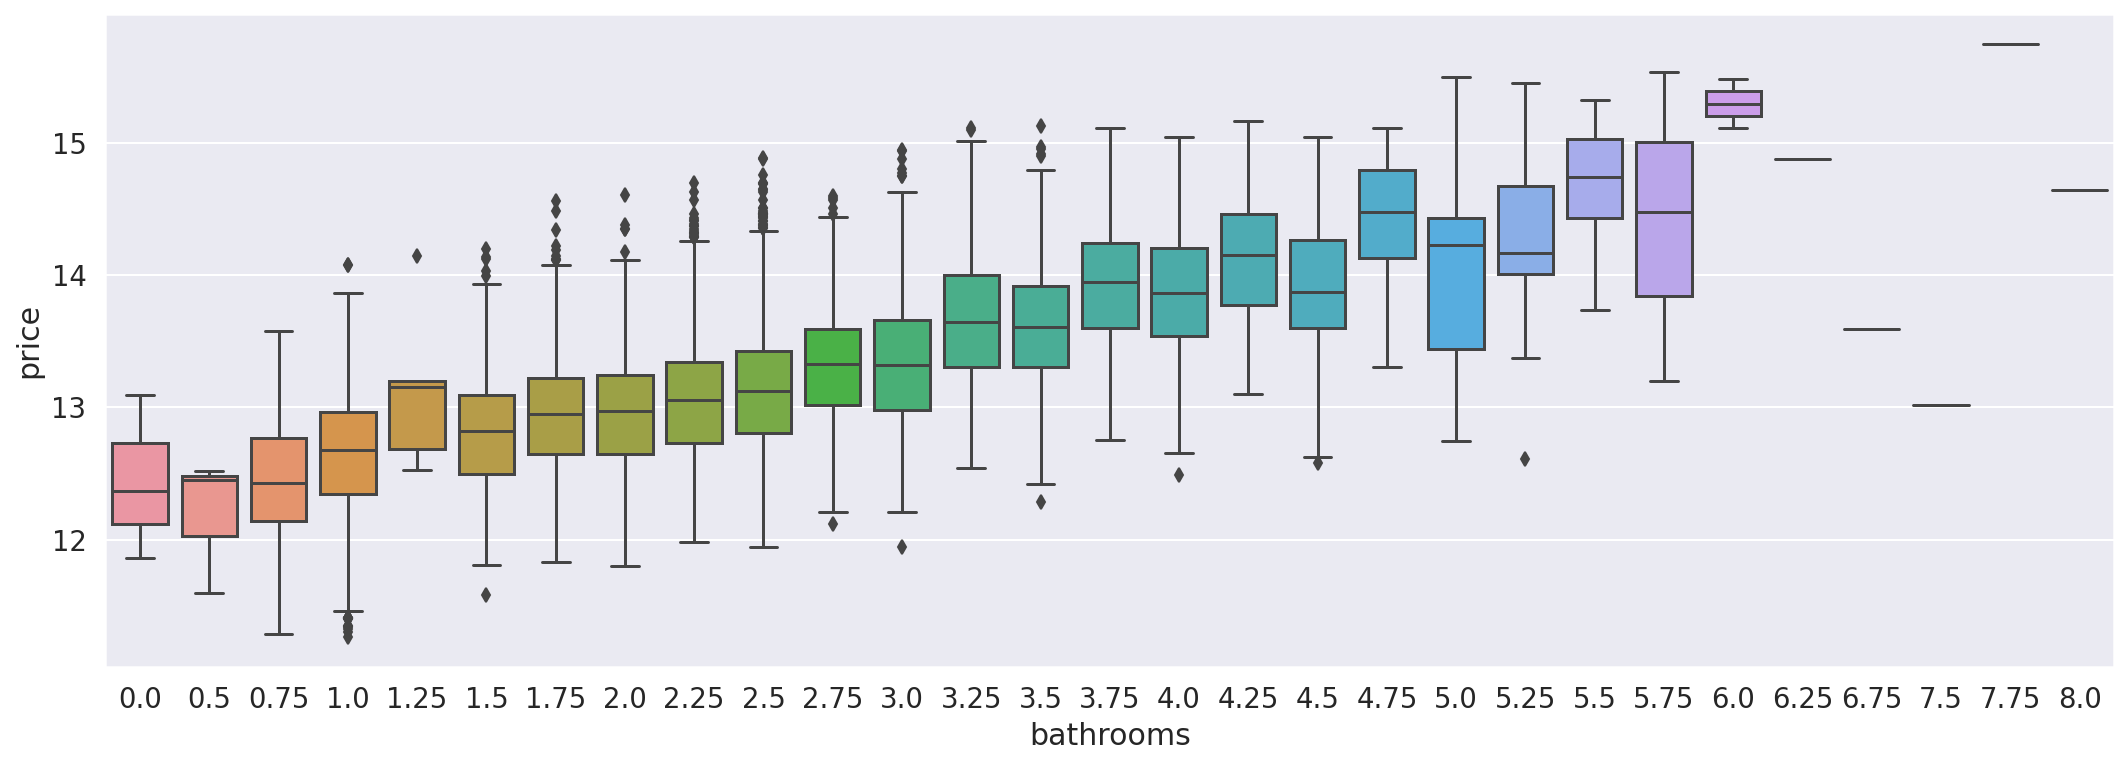

In [20]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

['bathrooms' 'sqft_living' 'sqft_above' 'grade' 'sqft_living15' 'yr_built'
 'floors' 'bedrooms' 'price' 'long']


<AxesSubplot:>

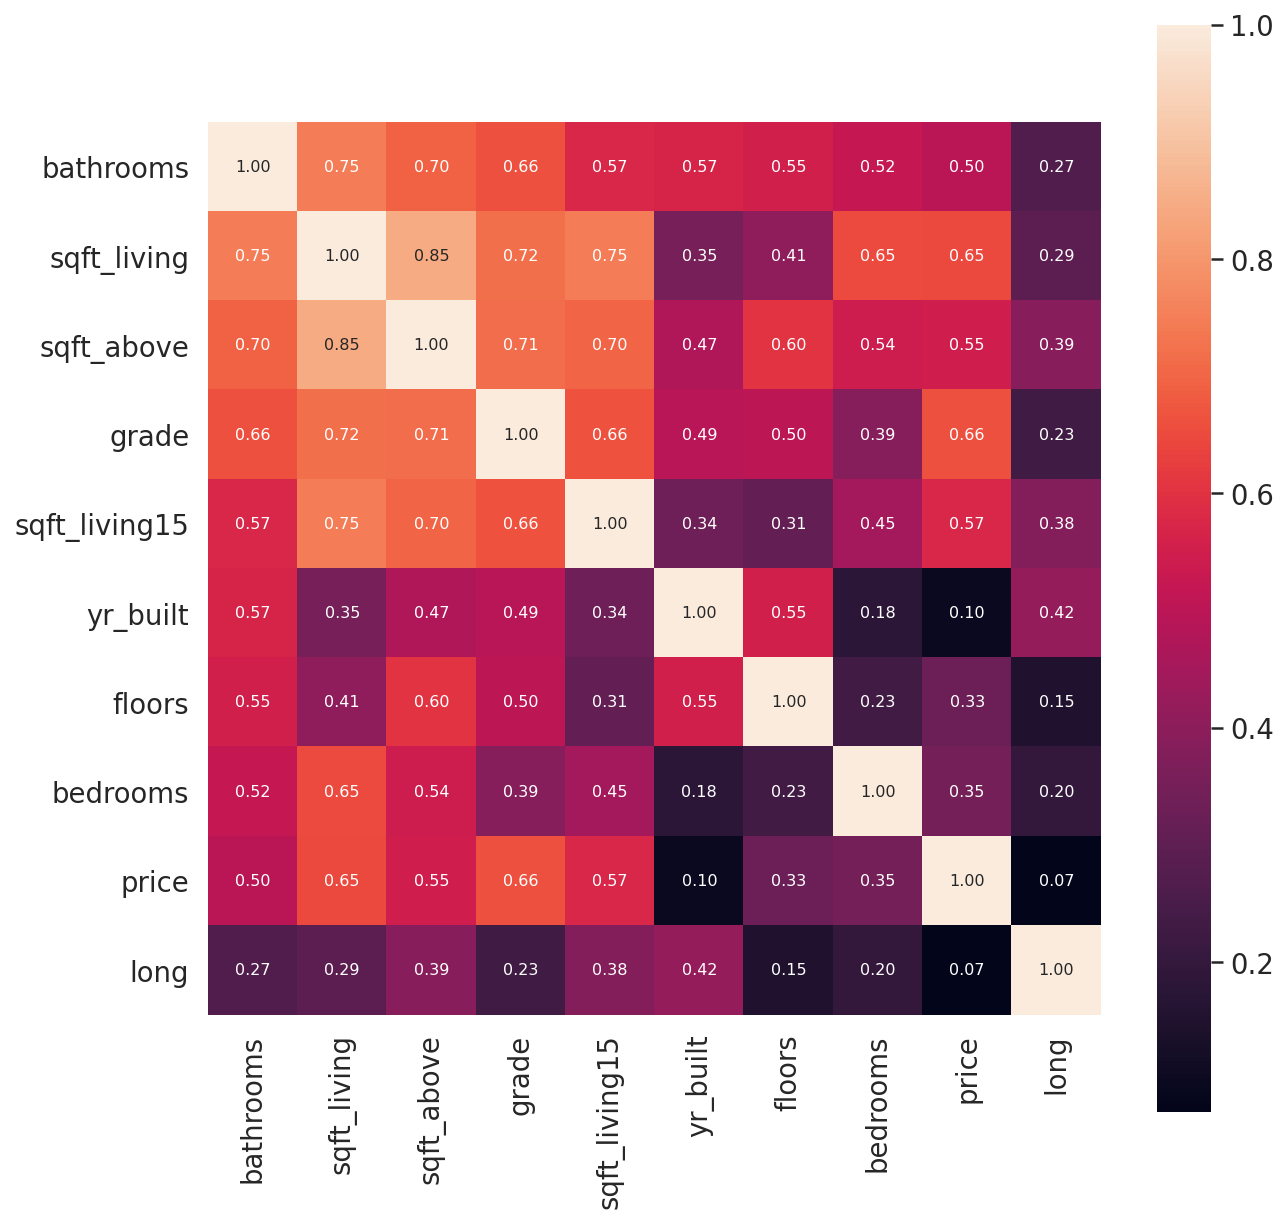

In [21]:
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='bathrooms').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

bathroom은 price보다는 다른 값들의 영향을 많이 받는군요. 그렇기 때문에 분포도가 넓게 퍼져 있어도 지우지 않고 처리하도록 합니다.

In [22]:
y = df_train['price']
del df_train['price']

print(df_train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [23]:
del df_train['id']

print(df_train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [24]:
df_test['date'] = df_test['date'].apply(lambda i: i[:6]).astype(int)

del df_test['id']

print(df_test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15029 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15029 non-null  object 
 1   bedrooms       15029 non-null  int64  
 2   bathrooms      15029 non-null  float64
 3   sqft_living    15029 non-null  int64  
 4   sqft_lot       15029 non-null  int64  
 5   floors         15029 non-null  float64
 6   waterfront     15029 non-null  int64  
 7   view           15029 non-null  int64  
 8   condition      15029 non-null  int64  
 9   grade          15029 non-null  int64  
 10  sqft_above     15029 non-null  int64  
 11  sqft_basement  15029 non-null  int64  
 12  yr_built       15029 non-null  int64  
 13  yr_renovated   15029 non-null  int64  
 14  zipcode        15029 non-null  int64  
 15  lat            15029 non-null  float64
 16  long           15029 non-null  float64
 17  sqft_living15  15029 non-null  int64  
 18  sqft_l

In [26]:
df_train.head
#왜 date가 object인가 했더니 전처리가 덜됐어요.

<bound method NDFrame.head of                   date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      20141013T000000         3       1.00         1180      5650     1.0   
1      20150225T000000         2       1.00          770     10000     1.0   
2      20150218T000000         3       2.00         1680      8080     1.0   
3      20140627T000000         3       2.25         1715      6819     2.0   
4      20150115T000000         3       1.50         1060      9711     1.0   
...                ...       ...        ...          ...       ...     ...   
15030  20141014T000000         4       2.50         2520      6023     2.0   
15031  20150326T000000         4       3.50         3510      7200     2.0   
15032  20140521T000000         3       2.50         1530      1131     3.0   
15033  20150223T000000         4       2.50         2310      5813     2.0   
15034  20141015T000000         2       0.75         1020      1076     2.0   

       waterfront  view  conditio

In [27]:
df_train['date'] = df_train['date'].apply(lambda i: i[:6]).astype(int)
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15029 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15029 non-null  int64  
 1   bedrooms       15029 non-null  int64  
 2   bathrooms      15029 non-null  float64
 3   sqft_living    15029 non-null  int64  
 4   sqft_lot       15029 non-null  int64  
 5   floors         15029 non-null  float64
 6   waterfront     15029 non-null  int64  
 7   view           15029 non-null  int64  
 8   condition      15029 non-null  int64  
 9   grade          15029 non-null  int64  
 10  sqft_above     15029 non-null  int64  
 11  sqft_basement  15029 non-null  int64  
 12  yr_built       15029 non-null  int64  
 13  yr_renovated   15029 non-null  int64  
 14  zipcode        15029 non-null  int64  
 15  lat            15029 non-null  float64
 16  long           15029 non-null  float64
 17  sqft_living15  15029 non-null  int64  
 18  sqft_l

# 모델설계

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [30]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [31]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [32]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
models = [gboost, xgboost, lightgbm, rdforest]

In [33]:
df = {}
for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__
    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(df_train, y, random_state=random_state, test_size=0.2)
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df


{'GradientBoostingRegressor': 140055.0234497827,
 'XGBRegressor': 116058.59422262819,
 'LGBMRegressor': 112119.40162050932,
 'RandomForestRegressor': 124734.77752998652}

In [34]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
#model = LGBMRegressor(random_state=random_state)

In [37]:
def my_GridSearch(model, df_train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(df_train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [38]:
param_grid = {
'objective':['regression'],
    'num_leaves' : [60],
    'learning_rate' : [0.05],
    'n_estimators':[1000],
    'max_bin' : [80],
    'n_estimators' : [100],
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, df_train, y, param_grid, verbose=2, n_jobs=5)

#파라미터 튜닝 - num_leaves 1->60/ n_estimators:1000 추가

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


,learning_rate,max_bin,n_estimators,num_leaves,objective,score,RMSLE
0,0.05,80,100,60,regression,-0.027838,0.166848


In [39]:
model = LGBMRegressor(max_depth=50, n_estimators=100, random_state=random_state)
model.fit(df_train, y)
prediction = model.predict(df_test)
prediction
#파라미터 튜닝 - max_dapth 10->50 으로 수정

array([13.1080113 , 13.04251535, 14.15234573, ..., 13.05702727,
       12.69184394, 12.96775993])

In [40]:
prediction = np.expm1(prediction)
prediction

array([ 492874.2130243 ,  461627.32280457, 1400507.19639336, ...,
        468375.28210684,  325084.64115871,  428376.43049605])

In [41]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [42]:
save_submission(model, df_train, y, df_test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/home/aiffel-dj57/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


# score : 114842.65541

# 배운것
# log함수를 취하는 이유

1. 0
<
x
<
1
 범위에서는 기울기가 매우 가파릅니다. 즉, 
x
의 구간은 
(
0
,
1
)
로 매우 짧은 반면, 
y
의 구간은 
(
−
∞
,
0
)
으로 매우 큽니다.

2. 따라서 0에 가깝게 모여있는 값들이 
x
로 입력되면, 그 함수값인 
y
 값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.
3. 반면, 
x
값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 이는 곧 큰 
x
값들에 대해서는 
y
값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 
x
를 비교적 작은 
y
값의 구간 내에 모이게 하는 특징을 가집니다.
위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있는 것이죠.

# 한계(ㅠㅠ)

- ensenble 기법을 아직 잘 모르겠다.
- def 함수를 능숙하게 사용하지 못한다.
- 데이터 분석을 더 잘 하고 싶다

# 후기
어려워요!